In [2]:
import jax
import jax.numpy as jnp

def gaussian_filter_jax(field, delta):
    """
    Apply a Gaussian filter to a field using spectral methods (Fourier space) in JAX.

    Parameters
    ----------
    field : jax.numpy.ndarray
        Input field (1D, 2D, or 3D).
    delta : float
        Filter width (standard deviation of the Gaussian).

    Returns
    -------
    filtered_field : jax.numpy.ndarray
        Gaussian-filtered field.
    """
    ndim = field.ndim
    shape = field.shape

    # Compute Fourier transform
    field_hat = jnp.fft.fftn(field)

    # Create wavenumber grids
    k_grids = [jnp.fft.fftfreq(n) * 2 * jnp.pi for n in shape]
    
    if ndim == 1:
        k_squared = k_grids[0] ** 2
    else:
        K = jnp.meshgrid(*k_grids, indexing='ij')
        k_squared = sum(k**2 for k in K)

    # Gaussian filter in Fourier space
    G_hat = jnp.exp(-0.5 * delta**2 * k_squared)

    # Apply filter
    filtered_hat = field_hat * G_hat

    # Inverse Fourier transform
    filtered_field = jnp.fft.ifftn(filtered_hat).real

    return filtered_field


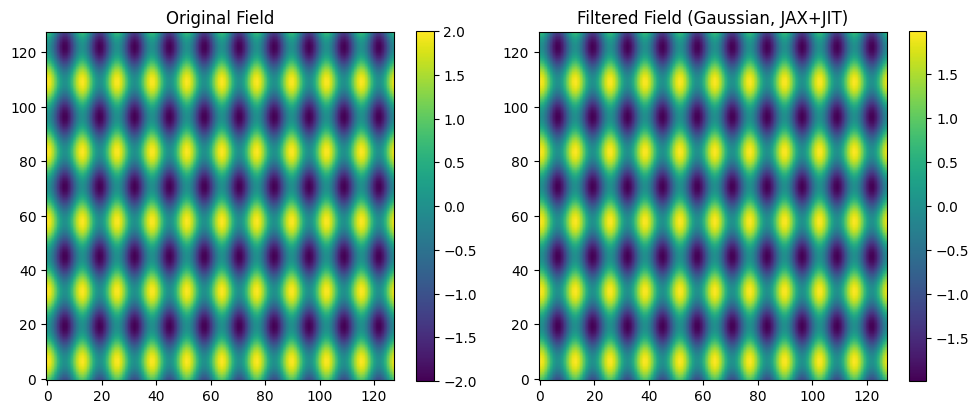

In [4]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# --------------------------------------------------------
# Assume gaussian_filter_jax(field, delta) is already defined
# (copy snippet 1 from earlier above this code)
# --------------------------------------------------------

# Example 2D grid
nx, ny = 128, 128
x = jnp.linspace(0, 2*jnp.pi, nx, endpoint=False)
y = jnp.linspace(0, 2*jnp.pi, ny, endpoint=False)
X, Y = jnp.meshgrid(x, y, indexing='ij')

# Define a synthetic test field
field = jnp.sin(5*X) + jnp.cos(10*Y)

# ---- Apply Gaussian filter with JIT ----
gaussian_filter_jax_jit = jax.jit(gaussian_filter_jax)
filtered_field = gaussian_filter_jax_jit(field, delta=0.2)

# ---- Plot original vs filtered ----
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Original Field")
plt.imshow(field, origin='lower', cmap='viridis')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Filtered Field (Gaussian, JAX+JIT)")
plt.imshow(filtered_field, origin='lower', cmap='viridis')
plt.colorbar()

plt.tight_layout()
plt.show()


delta=0.0982: trace mean=3.8882e-02, std=4.5431e-02; tau_xy mean=5.5040e-05, std=1.6036e-02
delta=0.1963: trace mean=1.3943e-01, std=1.5967e-01; tau_xy mean=1.7587e-04, std=5.5065e-02
delta=0.3927: trace mean=3.8715e-01, std=4.1132e-01; tau_xy mean=3.1896e-04, std=1.2926e-01


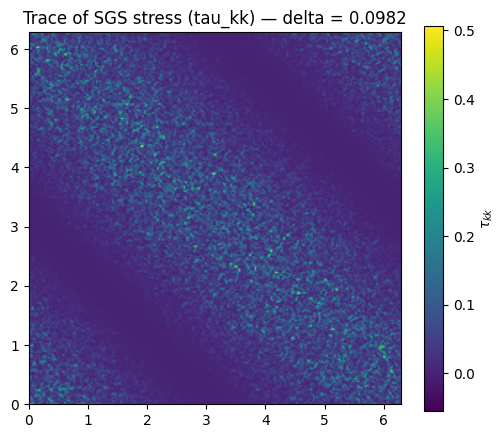

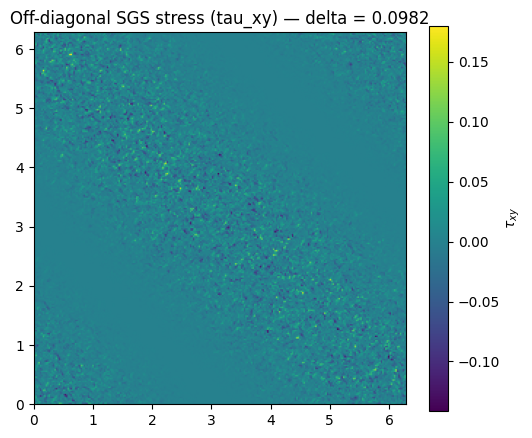

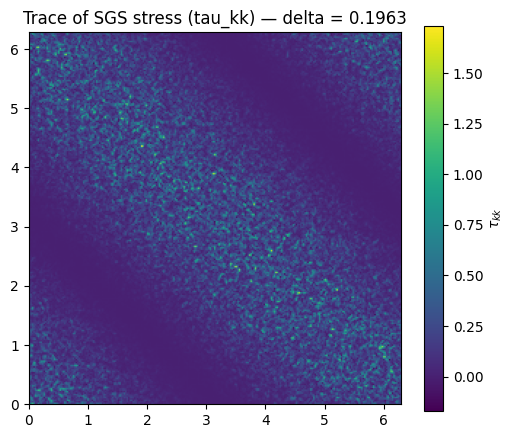

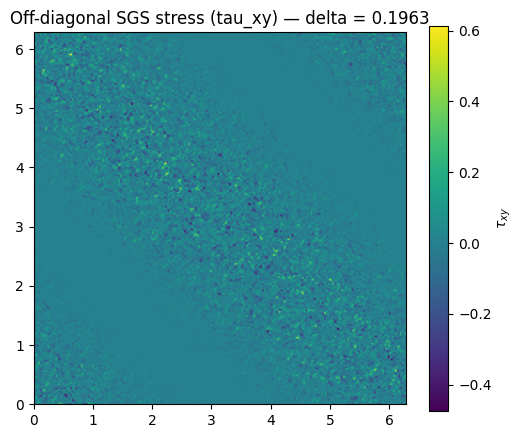

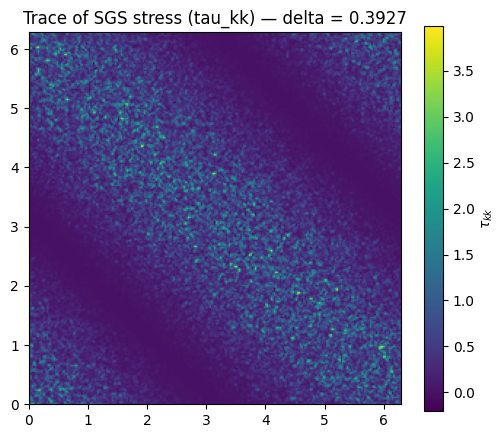

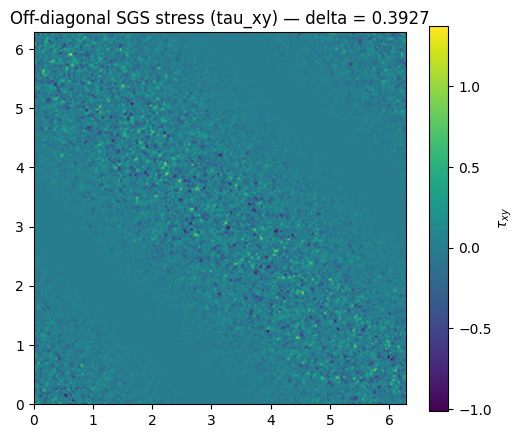

In [6]:
# jax_sgs_gaussian.py
# JAX implementation of SGS stress calculation with Gaussian spectral filter
# Uses pre-defined gaussian_filter_jax function

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt


# -------------------------
# Parameters
# -------------------------
N = 256                # grid resolution
L = 2 * jnp.pi         # domain size
dx = L / N
p = 3.0                # spectrum exponent for synthetic streamfunction

# -------------------------
# Wavenumber grids (angular)
# -------------------------
kx = jnp.fft.fftfreq(N, d=dx) * 2 * jnp.pi
ky = jnp.fft.fftfreq(N, d=dx) * 2 * jnp.pi
KX, KY = jnp.meshgrid(kx, ky, indexing='ij')
K2 = KX**2 + KY**2
K = jnp.sqrt(K2)
K = K.at[0,0].set(1.0)

# -------------------------
# Random streamfunction in Fourier space with Hermitian symmetry
# -------------------------
key = jax.random.PRNGKey(42)
phases = jax.random.uniform(key, shape=(N,N), minval=0.0, maxval=2*jnp.pi)
amp = K**(-p/2.0)
amp = amp.at[0,0].set(0.0)
psi_hat = amp * jnp.exp(1j * phases)
psi_hat = 0.5 * (psi_hat + jnp.conj(jnp.flip(jnp.flip(psi_hat, axis=0), axis=1)))
psi_hat = psi_hat.at[0,0].set(0.0)

psi = jnp.fft.ifft2(psi_hat).real

# -------------------------
# Velocities from streamfunction
# -------------------------
psi_hat = jnp.fft.fft2(psi)
u_hat = -1j * KY * psi_hat
v_hat =  1j * KX * psi_hat
u = jnp.fft.ifft2(u_hat).real
v = jnp.fft.ifft2(v_hat).real
rms = jnp.sqrt(jnp.mean(u**2 + v**2))
u = u / rms
v = v / rms

# -------------------------
# Compute SGS components for a list of deltas
# -------------------------
deltas = [L/64.0, L/32.0, L/16.0]

results = {}
for delta in deltas:
    ub = gaussian_filter_jax(u, delta)
    vb = gaussian_filter_jax(v, delta)
    uu_bar = gaussian_filter_jax(u * u, delta)
    vv_bar = gaussian_filter_jax(v * v, delta)
    uv_bar = gaussian_filter_jax(u * v, delta)

    tau_xx = uu_bar - ub * ub
    tau_yy = vv_bar - vb * vb
    tau_xy = uv_bar - ub * vb
    trace  = tau_xx + tau_yy

    results[float(delta)] = dict(
        tau_xx=tau_xx, tau_yy=tau_yy, tau_xy=tau_xy, trace=trace,
        ub=ub, vb=vb
    )

# -------------------------
# Plotting
# -------------------------
def to_np(x):
    return np.array(x)

for delta in deltas:
    d = float(delta)
    tau_trace = to_np(results[d]['trace'])
    tau_xy    = to_np(results[d]['tau_xy'])

    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(tau_trace.T, origin='lower', extent=(0,float(L),0,float(L)))
    ax.set_title(f"Trace of SGS stress (tau_kk) — delta = {d:.4f}")
    plt.colorbar(im, ax=ax, label=r'$\tau_{kk}$')

    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(tau_xy.T, origin='lower', extent=(0,float(L),0,float(L)))
    ax.set_title(f"Off-diagonal SGS stress (tau_xy) — delta = {d:.4f}")
    plt.colorbar(im, ax=ax, label=r'$\tau_{xy}$')

# -------------------------
# Print statistics
# -------------------------
for delta in deltas:
    d = float(delta)
    trace = to_np(results[d]['trace'])
    tau_xy = to_np(results[d]['tau_xy'])
    print(f"delta={d:.4f}: trace mean={trace.mean():.4e}, std={trace.std():.4e}; "
          f"tau_xy mean={tau_xy.mean():.4e}, std={tau_xy.std():.4e}")

plt.show()
